### Notice!!! Please use search function to check all the cells with "notice" keywords, those are sanity checks and potential manual variable changes

In [0]:
#########################################################################################################
# Please define the target Timestamp for the end date for the generation of COVID patients dataset
# Notice: Format: YYYY-MM-DD
# Current set to 2021-12-10
############################################################################################################
# check to make sure they are consistent
# Previous dates used:
# 1. "2021-12-31", "20211231"
# 2. "2022-02-18", "20220218"
# 3. end_date, file_date = "2021-12-25", "20211225"
# end_date, file_date = "2021-12-21", "20211221"

start_date, end_date, file_date = "2020-03-01", "2021-12-25", "20211225_Lancet_bmi"
# register it so can be directly used in the following SQL statement
spark.conf.set("enddate.var", end_date)

In [0]:
#pip install xgboost
#pip install joblib
#pip install scikit-learn
#pip install shap

### Keep the follow cell empty can copy all the install commands and run them one by one

In [0]:
import numpy as np
import pandas as pd
import shap

## Scikit-learn related
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.linear_model import SGDClassifier
# from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier
# from sklearn.neighbors import KNeighborsClassifier
## from sklearn import cross_validation, metrics   #Additional scklearn functions, deprecated since version 0.18
## from sklearn.grid_search import GridSearchCV   #!!!the grid search package that has issue, dont use it
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from scipy import interp
from scipy import stats

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

#######################################
## Enable parallel threading in pyspark
from joblibspark import register_spark
from sklearn.utils import parallel_backend
register_spark() ## register spark backend

########################################
## Import those from pyspark.ml
import pyspark.ml
import pyspark.sql.functions as F

In [0]:
imids_training_df = spark.sql("""SELECT * FROM rdp_phi_sandbox.qw_IMID_COVID_trainset_cond_med_vax_{}""".format(file_date)) 
# imids_training_df.limit(5).toPandas()

In [0]:
imids_training_df = imids_training_df.dropDuplicates()
# imids_training_df.limit(5).toPandas()

In [0]:
## Drop not used columns
col_to_drop = ('age_range', 'ethnicity', 'race1', 'race_v2', 'ethnicity_race', 'CVX_name', 'decided_index_date', 'CVX_name')
imids_training_df = imids_training_df.drop(*col_to_drop)

## rename IMIDs drugs columns
imids_training_df = imids_training_df.withColumnRenamed('prior_91_days_hydroxychloroquine_logic', 'hydroxychloroquine').withColumnRenamed('prior_91_days_methotrexate_logic', 'methotrexate')\
.withColumnRenamed('prior_91_days_leflunomide_teriflunomide_logic', 'leflunomide_teriflunomide').withColumnRenamed('prior_91_days_5_ASAa_logic', '5_ASA')\
.withColumnRenamed('prior_91_days_azathioprine_logic', 'azathioprine').withColumnRenamed('prior_91_days_mercaptopurine_logic', 'mercaptopurine')\
.withColumnRenamed('prior_91_days_mitoxantrone_logic', 'mitoxantrone')\
.withColumnRenamed('prior_91_days_mycophenolate_logic', 'mycophenolate').withColumnRenamed('prior_91_days_calcineurin_inhibitor_logic', 'calcineurin_inhibitor')\
.withColumnRenamed('prior_91_days_TNF_alpha_inhibitor_logic', 'TNF_alpha_inhibitor').withColumnRenamed('prior_91_days_fumarates_logic', 'fumarates')\
.withColumnRenamed('prior_91_days_interferons_logic', 'interferons').withColumnRenamed('prior_91_days_alkylating_agent_logic', 'alkylating_agent')\
.withColumnRenamed('prior_91_days_hydroxyurea_logic', 'hydroxyurea').withColumnRenamed('prior_91_days_dapsone_logic', 'dapsone')\
.withColumnRenamed('prior_91_days_cladribine_logic', 'cladribine').withColumnRenamed('prior_91_days_IL1_inhibitor_logic', 'IL1_inhibitor')\
.withColumnRenamed('prior_91_days_IL6_inhibitor_logic', 'IL6_inhibitor').withColumnRenamed('prior_91_days_IL12_23_inhibitor_logic', 'IL12_23_inhibitor')\
.withColumnRenamed('prior_91_days_IL17_inhibitor_logic', 'IL17_inhibitor')\
.withColumnRenamed('prior_91_days_IL23_inhibitor_logic', 'IL23_inhibitor')\
.withColumnRenamed('prior_91_days_abatacept_logic', 'abatacept').withColumnRenamed('prior_91_days_anti_BLyS_logic', 'anti_BLyS')\
.withColumnRenamed('prior_91_days_S1P_receptor_modulator_logic', 'S1P_receptor_modulator').withColumnRenamed('prior_91_days_JAK_inhibitor_logic', 'JAK_inhibitor')\
.withColumnRenamed('prior_91_days_integrin_inhibitor_logic', 'integrin_inhibitor').withColumnRenamed('prior_91_days_PDE4i_targeted_synthetic_logic', 'PDE4i_targeted_synthetic')\
.withColumnRenamed('prior_91_days_anti_CD20_logic', 'anti_CD20').withColumnRenamed('prior_91_days_anti_CD52_logic', 'anti_CD52')\
.withColumnRenamed('prior_91_days_budesonide_logic', 'budesonide').withColumnRenamed('prior_91_days_systemic_glucocorticoids_logic', 'systemic_glucocorticoids')\
.withColumnRenamed('after_10_days_monoclonal_antibody_covid_19_logic', 'monoclonal_antibody_covid_19')

In [0]:
## Temp solution, filter the positive patient here
pos_df = imids_training_df.filter(imids_training_df['results'] == "Positive")

## convert to pandas dataframe
# imids_training_pd_df = imids_training_onlyPos_df.toPandas()
 
## col names before dropping any
# list(imids_training_pd_df.columns)

In [0]:
## One hot-encode sex
categ = pos_df.select('sex').distinct().rdd.flatMap(lambda x:x).collect()
exprs = [F.when(F.col('sex') == cat,1).otherwise(0)\
            .alias(str("sex_" + cat)) for cat in categ]
pos_one_hot_df = pos_df.select(pos_df.columns + exprs)

## Fill none values in the vaccination column
pos_one_hot_df = pos_one_hot_df.fillna({'Vaccination_status':'Not'})

## One hot-encode vaccination
categ = pos_one_hot_df.select('Vaccination_status').distinct().rdd.flatMap(lambda x:x).collect()
exprs = [F.when(F.col('Vaccination_status') == cat,1).otherwise(0)\
            .alias(str("vaccination_" + cat)) for cat in categ]
pos_one_hot_df = pos_one_hot_df.select(pos_one_hot_df.columns + exprs)

## Drop not needed cols and original cols
pos_one_hot_df = pos_one_hot_df.drop("sex").drop("sex_Female").drop("sex_Unknown").drop("Vaccination_status").drop("vaccination_Not")

## change the name of those vaccination related columns
pos_one_hot_df = pos_one_hot_df.withColumnRenamed('vaccination_Fully', 'fully_vaccinated').withColumnRenamed('vaccination_Booster', 'boosted')

In [0]:
# ## Manually define the min max process
# from pyspark.sql.functions import max, min, mean, col

# max_age, min_age = pos_one_hot_df.select(max("age"), min("age")).first()
# pos_one_hot_minmax_df = pos_one_hot_df.withColumn("age_normalized", (col("age") - min_age) / (max_age - min_age) )
# pos_one_hot_minmax_df = pos_one_hot_minmax_df.drop("age")

In [0]:
train_df = pos_one_hot_df.select("*")
train_df = train_df.drop("pat_id").drop("results")

## Drop SVI and geocoding features due to high missing percentage
## list: 'SVI_Socioeconomic', 'SVI_Household_Composition_Disability', 'SVI_Minority_Status_Language', 'SVI_Housing_Type_Transportation', 'SVI', 'Metro_area', 'Low_education', 'Low_employment',
## not including 'obesity'

train_df = train_df.select('patient_id', 'hospitalized_after_positive','IMV_after_positive','death_after_positive',
  'age', 'BMI', 'sex_Male',
  'hypertension', 'diabetes_type1and2', 'atrial_fibrillation', 'coronary_artery_disease', 'heart_failure', 'chronic_kidney_disease', 'copd', 'chronic_liver_disease', 'malignant_neoplastic_disease', 'asthma', 'HIV', 'history_transplant', 'stroke', 'opioid_dependence', 'fully_vaccinated', 'boosted', 
 'ibd', 'rheumatoid_arthritis', 'multiple_sclerosis','psoriatic_arthritis', 'psoriasis', 'systemic_sclerosis', 'spondyloarthritis', 'systemic_lupus', 'vasculitis', 'sarcoidosis', 'APS', 'sjogren_syndrome',
 'hydroxychloroquine',
 'methotrexate',
 'leflunomide_teriflunomide',
 '5_ASA',
 'azathioprine',
 'mercaptopurine',
 'mitoxantrone',
 'mycophenolate',
 'calcineurin_inhibitor',
 'TNF_alpha_inhibitor',
 'fumarates',
 'interferons',
 'alkylating_agent',
 'hydroxyurea',
 'dapsone',
 'cladribine',
 'IL1_inhibitor',
 'IL6_inhibitor',
 'IL12_23_inhibitor',
 'IL17_inhibitor',
 'IL23_inhibitor',
 'abatacept',
 'anti_BLyS',
 'S1P_receptor_modulator',
 'JAK_inhibitor',
 'integrin_inhibitor',
 'PDE4i_targeted_synthetic',
 'anti_CD20',
 'anti_CD52',
 'budesonide',
 'systemic_glucocorticoids',
 'monoclonal_antibody_covid_19')

In [0]:
train_pd_df = train_df.toPandas()
## change the patient id col to be the index of the training data
train_pd_df = train_pd_df.set_index("patient_id")
display(train_pd_df)

## Training data preprocessing
* Assign features for training data to X
* Assign response to Y
* Define the number of CV & random seed used for tuning

In [0]:
#######################################################
#Random search CV method
#and
#Multi class roc_auc score method
########################################################
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer, roc_auc_score

###############################################################################################
#Binary class roc auc score method
#input: y_true, true labels from test fold
#       y_score, predicted probability on test fold
#       average, string, [None, ‘micro’, ‘macro’ (default), ‘samples’, ‘weighted’]
#                'macro': Calculate metrics for each label, and find their unweighted mean. 
#                This does not take label imbalance into account.
#                'weighted': Calculate metrics for each label, and find their average, 
#                weighted by support (the number of true instances for each label).
#output: auroc value for each class
#############################################################################################
def binary_class_roc_auc_score(y_true, y_score, average="weighted"):

    return roc_auc_score(y_true, y_score, average=average)

binaryclass_score = make_scorer(binary_class_roc_auc_score, needs_threshold = True)

In [0]:
## not including: , 'obesity'
train_pd_df.columns = ['hospitalized_after_positive', 'IMV_after_positive', 'death_after_positive', 'age', 'BMI', 'sex:male', 'hypertension', 'diabetes (type 1+2)', 'atrial fibrillation', 'coronary artery disease', 'heart failure', 'chronic kidney disease', 'COPD', 'chronic liver disease', 'malignant neoplastic disease', 'asthma', 'HIV', 'history of transplant', 'stroke', 'opioid dependence', 'fully vaccinated', 'boosted', 
 'inflammatory bowel disease', 'rheumatoid arthritis', 'multiple sclerosis','psoriatic arthritis', 'psoriasis', 'systemic sclerosis', 'spondyloarthritis', 'systemic lupus', 'vasculitis', 'sarcoidosis', 'antiphospholipid syndrome', 'Sjögren syndrome',
 'hydroxychloroquine',
 'methotrexate',
 'leflunomide teriflunomide',
 '5-ASA',
 'azathioprine',
 'mercaptopurine',
 'mitoxantrone',
 'mycophenolate',
 'calcineurin inhibitor',
 'TNF-α inhibitor',
 'fumarates',
 'interferons',
 'alkylating agent',
 'hydroxyurea',
 'dapsone',
 'cladribine',
 'IL-1 inhibitor',
 'IL-6 inhibitor',
 'IL-12/23 inhibitor',
 'IL-17 inhibitor',
 'IL-23 inhibitor',
 'abatacept',
 'anti-BLyS',
 'S1P receptor modulator',
 'JAK inhibitor',
 'integrin inhibitor',
 'PDE4i targeted synthetic',
 'anti-CD20',
 'anti-CD52',
 'budesonide',
 'systemic glucocorticoids', 'monoclonal antibody covid-19']

In [0]:
## Columns to drop based on VIF results
# train_pd_df.drop(['SVI'], axis = 1, inplace = True)
# train_pd_df.drop(['mitoxantrone'], axis = 1, inplace = True)
# train_pd_df.drop(['anti_CD52'], axis = 1, inplace = True)
# train_pd_df.drop(['monoclonal_antibody_covid_19'], axis = 1, inplace = True)


percent_missing = train_pd_df.isnull().sum() * 100 / len(train_pd_df)
missing_value_df = pd.DataFrame({'column_name': train_pd_df.columns,
                                 'percent_missing': percent_missing})

display(missing_value_df)

## Fill NA values
## Method 1: Remove rows with at least one null value
# train_pd_noNull_df = train_pd_df.dropna()

## Notice
## Remove mAbs, antibody feature here
train_pd_df.drop(['monoclonal antibody covid-19'], axis = 1, inplace = True)

column_name,percent_missing
hospitalized_after_positive,0.0
IMV_after_positive,0.0
death_after_positive,0.0
age,0.0
BMI,0.0
sex:male,0.0
hypertension,0.0
diabetes (type 1+2),0.0
atrial fibrillation,0.0
coronary artery disease,0.0


In [0]:
## manually set the random seed to define a replication
r_seed = 42
print("current random seed is: ", r_seed)

## manually set the number for cross validation
num_cv = 10
print("current CV fold selection is: ", num_cv)

## Possible response vectors
Y_cols = ["hospitalized_after_positive", 'IMV_after_positive', 'death_after_positive']

## separate X and Y
train_df_Y = train_pd_df[Y_cols]
train_df_X = train_pd_df.drop(Y_cols, axis=1)

## Create composite response vectors
train_df_Y_new = pd.DataFrame(train_df_Y, columns = Y_cols)

train_df_Y_new['hospitalized_or_IMV_or_death'] = train_df_Y['hospitalized_after_positive'] + train_df_Y['IMV_after_positive'] + train_df_Y['death_after_positive']
train_df_Y_new['IMV_or_death'] = train_df_Y['IMV_after_positive'] + train_df_Y['death_after_positive']

## Convert those >1 values back to 1
train_df_Y_new.loc[train_df_Y_new['hospitalized_or_IMV_or_death'] >= 1, 'hospitalized_or_IMV_or_death'] = 1
train_df_Y_new.loc[train_df_Y_new['IMV_or_death'] >= 1, 'IMV_or_death'] = 1

current random seed is: 42
current CV fold selection is: 10

In [0]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = train_df_X.columns

# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(train_df_X.values, i) for i in range(len(train_df_X.columns))]

# display(vif_data)

## Response == "death"

In [0]:
###############################################################################
## Current Y as response
## Notice: need manual check
## Possible options: hospitalized, invasive_mechanical_vent, death, results
################################################################################
import xgboost
select_col = 'death_after_positive'
Y = train_df_Y_new[select_col]
# Y = Y.map(dict(yes=1, no=0))

class_names = np.unique(Y)
print("unique labels from y: ", class_names)

## Train test split use r_seed assigned in CMD 1
X = train_df_X

## sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None), default: stratify = None is not using stratified fashion
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=r_seed, stratify = Y)

## Normalize after the train/test split to avoid any potential data leakage
## using the min and max from the trainset to do minmax on test set
age_min, age_max = X_train["age"].min(), X_train["age"].max()
X_train["age"] = (X_train["age"] - age_min) / (age_max - age_min)
X_test["age"] = (X_test["age"] - age_min) / (age_max - age_min)

BMI_min, BMI_max = X_train["BMI"].min(), X_train["BMI"].max()
X_train["BMI"] = (X_train["BMI"] - BMI_min) / (BMI_max - BMI_min)
X_test["BMI"] = (X_test["BMI"] - BMI_min) / (BMI_max - BMI_min)

## Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)
ratio = ( np.size(y_train) - np.sum(y_train) ) / np.sum(y_train)
print("The ratio of negatives/positives is the the value of scale_pos_weight: ", ratio)

unique labels from y: [0 1]
The ratio of negatives/positives is the the value of scale_pos_weight: 31.10766002098636

## Hyperparameter tuning
* Use Random Search CV for a wider range of parameters searching
* use Grid Search CV for fine tuning

In [0]:
###########################################################
##Random search Tune
##learning rate, n_estimators, and booster
##
##########################################################
param_test_this_loop = {
 'learning_rate':[0.01, 0.02, 0.05, 0.1],
 'n_estimators':[i for i in range(5, 200, 5)],
 'max_depth':[i for i in range(2, 15, 1)],
 'min_child_weight':[i for i in range(0, 50, 5)],
 'subsample':[i/100.0 for i in range(40,100,10)],
 'colsample_bytree':[i/100.0 for i in range(40,100,10)],
 'reg_alpha':[i for i in range(0,5)],
 'reg_lambda':[i for i in range(1,5)],
  ## Balancing of positive and negative weights.
 'scale_pos_weight': [ratio],
 'booster':['gbtree'],
 'random_state':[r_seed],
 'use_label_encoder': [False]
}

cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)
rsearch_loop = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = param_test_this_loop, n_iter = 1500, scoring="roc_auc",n_jobs=None, cv=cv, verbose=1)

with parallel_backend('spark', n_jobs=318):
  rsearch_loop.fit(X_train,y_train, eval_metric='auc')

User-specified n_jobs (318) is greater than the max number of concurrent tasks (304) this cluster can run now.If dynamic allocation is enabled for the cluster, you might see more executors allocated.
Fitting 10 folds for each of 1500 candidates, totalling 15000 fits
User-specified n_jobs (318) is greater than the max number of concurrent tasks (304) this cluster can run now.If dynamic allocation is enabled for the cluster, you might see more executors allocated.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

In [0]:
rsearch_loop.best_params_, rsearch_loop.best_score_

Out[19]: ({'use_label_encoder': False,
 'subsample': 0.6,
 'scale_pos_weight': 31.10766002098636,
 'reg_lambda': 4,
 'reg_alpha': 1,
 'random_state': 42,
 'n_estimators': 175,
 'min_child_weight': 30,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.4,
 'booster': 'gbtree'},
 0.9170448371985824)

In [0]:
###########################################################
#Grid search Tune learning rate, n_estimators, and booster
#
##########################################################
# param_test_this_loop = {
#  'learning_rate':[0.2],
#  'n_estimators':[i for i in range(50, 60, 1)],
#  'max_depth':[i for i in range(8, 10, 1)],
#  'min_child_weight':[i for i in range(37, 42, 1)],
#  'subsample':[0.7],
#  'colsample_bytree':[0.7],
#  'reg_alpha':[0],
#  'reg_lambda':[2],
  
#  'random_state':[r_seed],
#   'use_label_encoder': [False]
# }
# cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

# gsearch_loop1 = GridSearchCV(estimator = XGBClassifier(), param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=None, cv=cv,verbose=1)

# with parallel_backend('spark', n_jobs=-1):
#   gsearch_loop1.fit(X_train,y_train, eval_metric='auc')

In [0]:
# gsearch_loop1.best_params_, gsearch_loop1.best_score_

In [0]:
###########################
# training a XGBoost model
##########################
# if using the randomSearch method
xgb = rsearch_loop.best_estimator_

## if using GridSearch method
# xgb = gsearch_loop1.best_estimator_

## if load the trained parameters
# xgb = XGBClassifier(use_label_encoder=False,
#   subsample=0.8,
#   scale_pos_weight=ratio,
#   reg_lambda=3,
#   reg_alpha=2,
#   random_state=r_seed,
#   n_estimators=190,
#   min_child_weight=35,
#   max_depth=4,
#   learning_rate=0.05,
#   colsample_bytree=0.7,
#   booster='gbtree')

# with parallel_backend('spark', n_jobs=-1):
#   xgb.fit(X_train,y_train, eval_metric='auc')

##!!!!
## notice that mean of auroc of each fold is different from the auroc calculated by all the predicted probability
## Result on test set
y_xgb_prob = xgb.predict_proba(X_test)

# calculate the auroc by directly using the binaryiclass_roc_auc_score scorer
xgb_binaryclass_auroc = binary_class_roc_auc_score(y_test, y_xgb_prob[:,1], average="weighted")

#print(xgb)

In [0]:
print("Auroc on test data set: %0.5f" % (xgb_binaryclass_auroc))

Auroc on test data set: 0.91489

In [0]:
#count the importance of features, and see actually how many are useful
print("Number of features have importance greater than zero: ", np.count_nonzero(xgb.feature_importances_))

## Print out the feature importance dataframe
## Python 3 to get list of tuples from two lists
data_tuples = list(zip(list(X_train.columns), xgb.feature_importances_))
feature_importance_df = pd.DataFrame(data_tuples, columns=['Feature name','Feature Importance'])
display(feature_importance_df)

Number of features have importance greater than zero: 33

Feature name,Feature Importance
age,0.16190125048160553
BMI,0.014534357003867626
sex:male,0.021065209060907364
hypertension,0.02853214181959629
diabetes (type 1+2),0.03432765230536461
atrial fibrillation,0.09275183081626892
coronary artery disease,0.006761182099580765
heart failure,0.06343711912631989
chronic kidney disease,0.11303918063640594
COPD,0.030011704191565514


In [0]:
## this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
import shap

###################################################
## model_output: “raw”, “probability”, “log_loss”
## feature_perturbation“interventional” (default) or “tree_path_dependent” (default when data=None)

## The “interventional” approach breaks the dependencies between features according to the rules dictated by casual inference (Janzing et al. 2019). Note that the “interventional” option requires a background dataset and its runtime scales linearly with the size of the background dataset you use. Anywhere from 100 to 1000 random background samples are good sizes to use. The “tree_path_dependent” approach is to just follow the trees and use the number of training examples that went down each leaf to represent the background distribution.

## For regression models “raw” is the standard output, for binary classification in XGBoost this is the log odds ratio. If model_output is the name of a supported prediction method on the model object then we explain the output of that model method name. For example model_output=”predict_proba” explains the result of calling model.predict_proba. If “probability” then we explain the output of the model transformed into probability space (note that this means the SHAP values now sum to the probability output of the model). 
######################################################
# explainer = shap.TreeExplainer(xgb, model_output='raw')

# explainer = shap.TreeExplainer(xgb, data = X_train, model_output='raw', feature_perturbation='interventional')
explainer = shap.TreeExplainer(xgb, data = None, model_output='raw', feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation
shap_values_arrary = explainer(X_train) 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

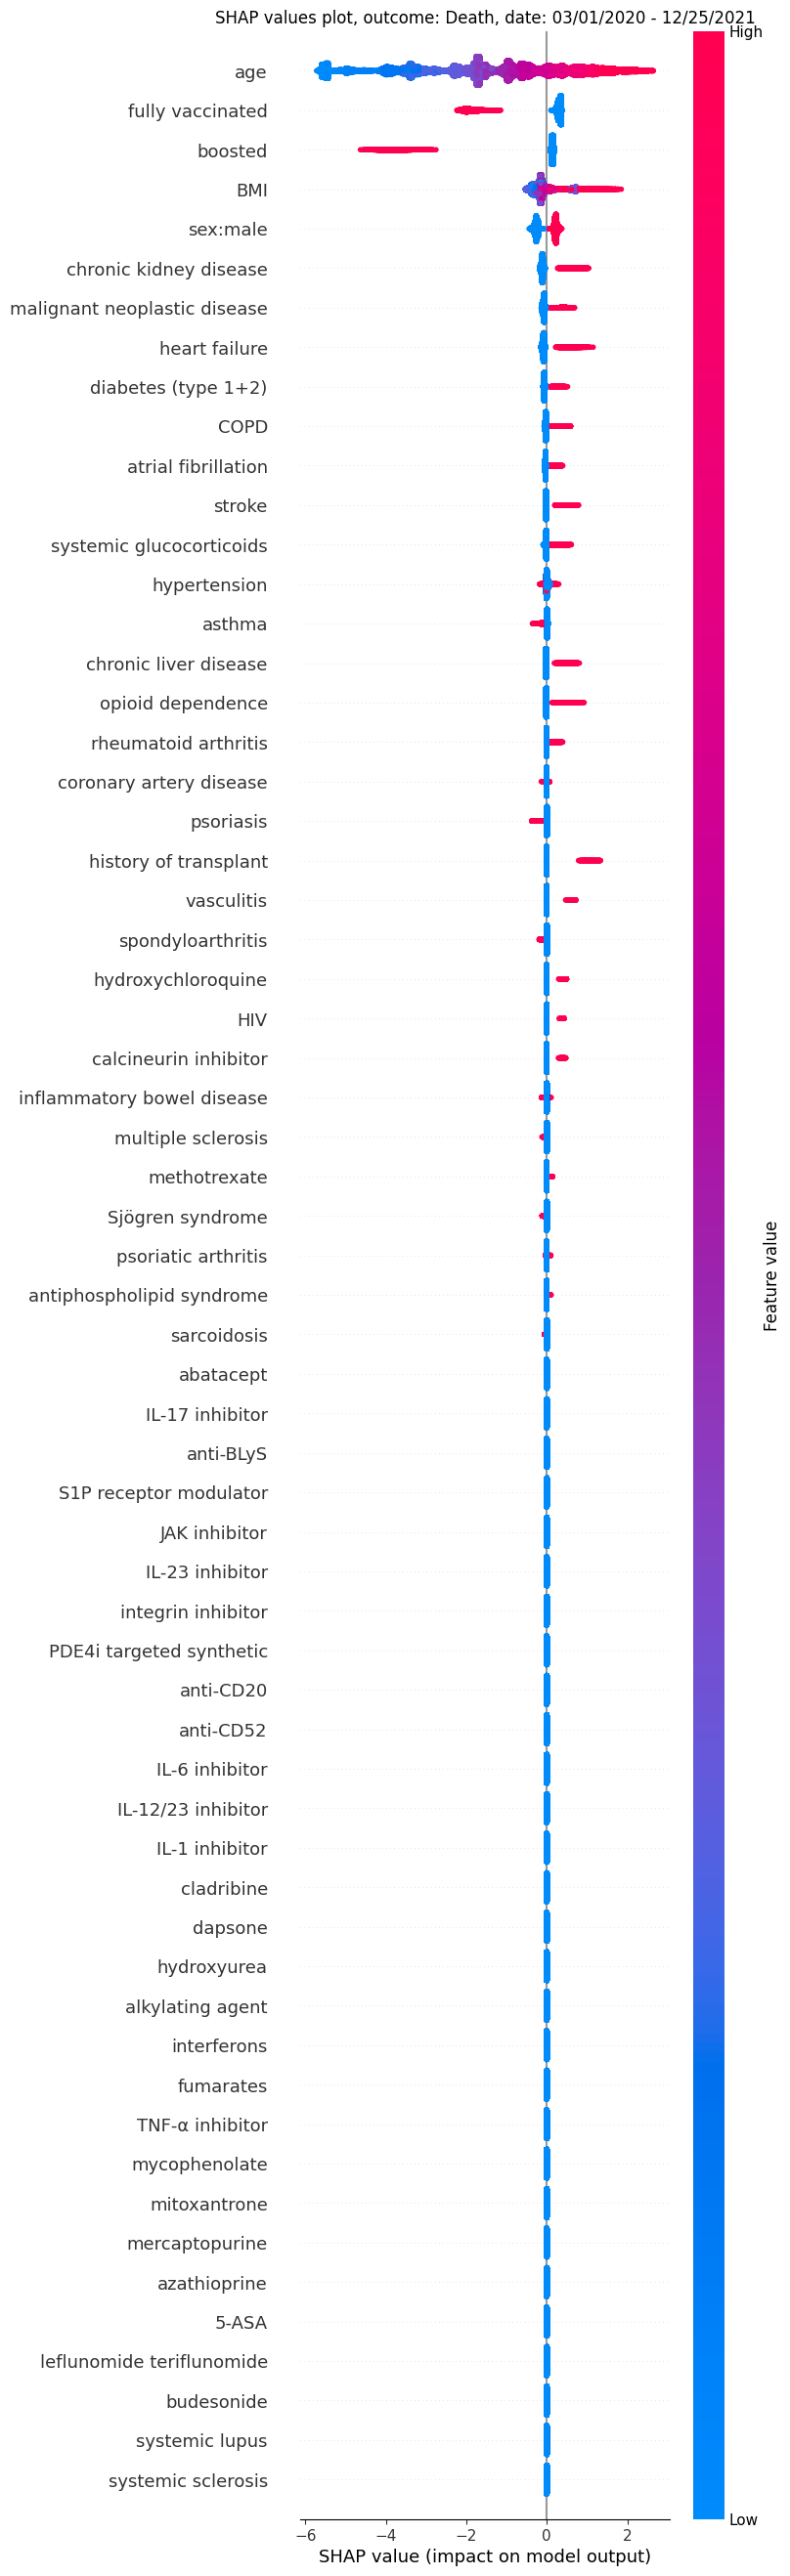

In [0]:
import matplotlib.pyplot as plt

## create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values_arrary[:,"age"], alpha=0.1)

## changing the rc parameters and plotting a line plot, the dpi function works!
plt.rcParams['figure.dpi'] = 100

shap.summary_plot(shap_values, X_train, max_display=X_train.shape[1], show = False)

plt.title("SHAP values plot, outcome: Death, date: 03/01/2020 - 12/25/2021")
# plt.ylabel("SHAP value for the 'Age' feature")
# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want

plt.show()

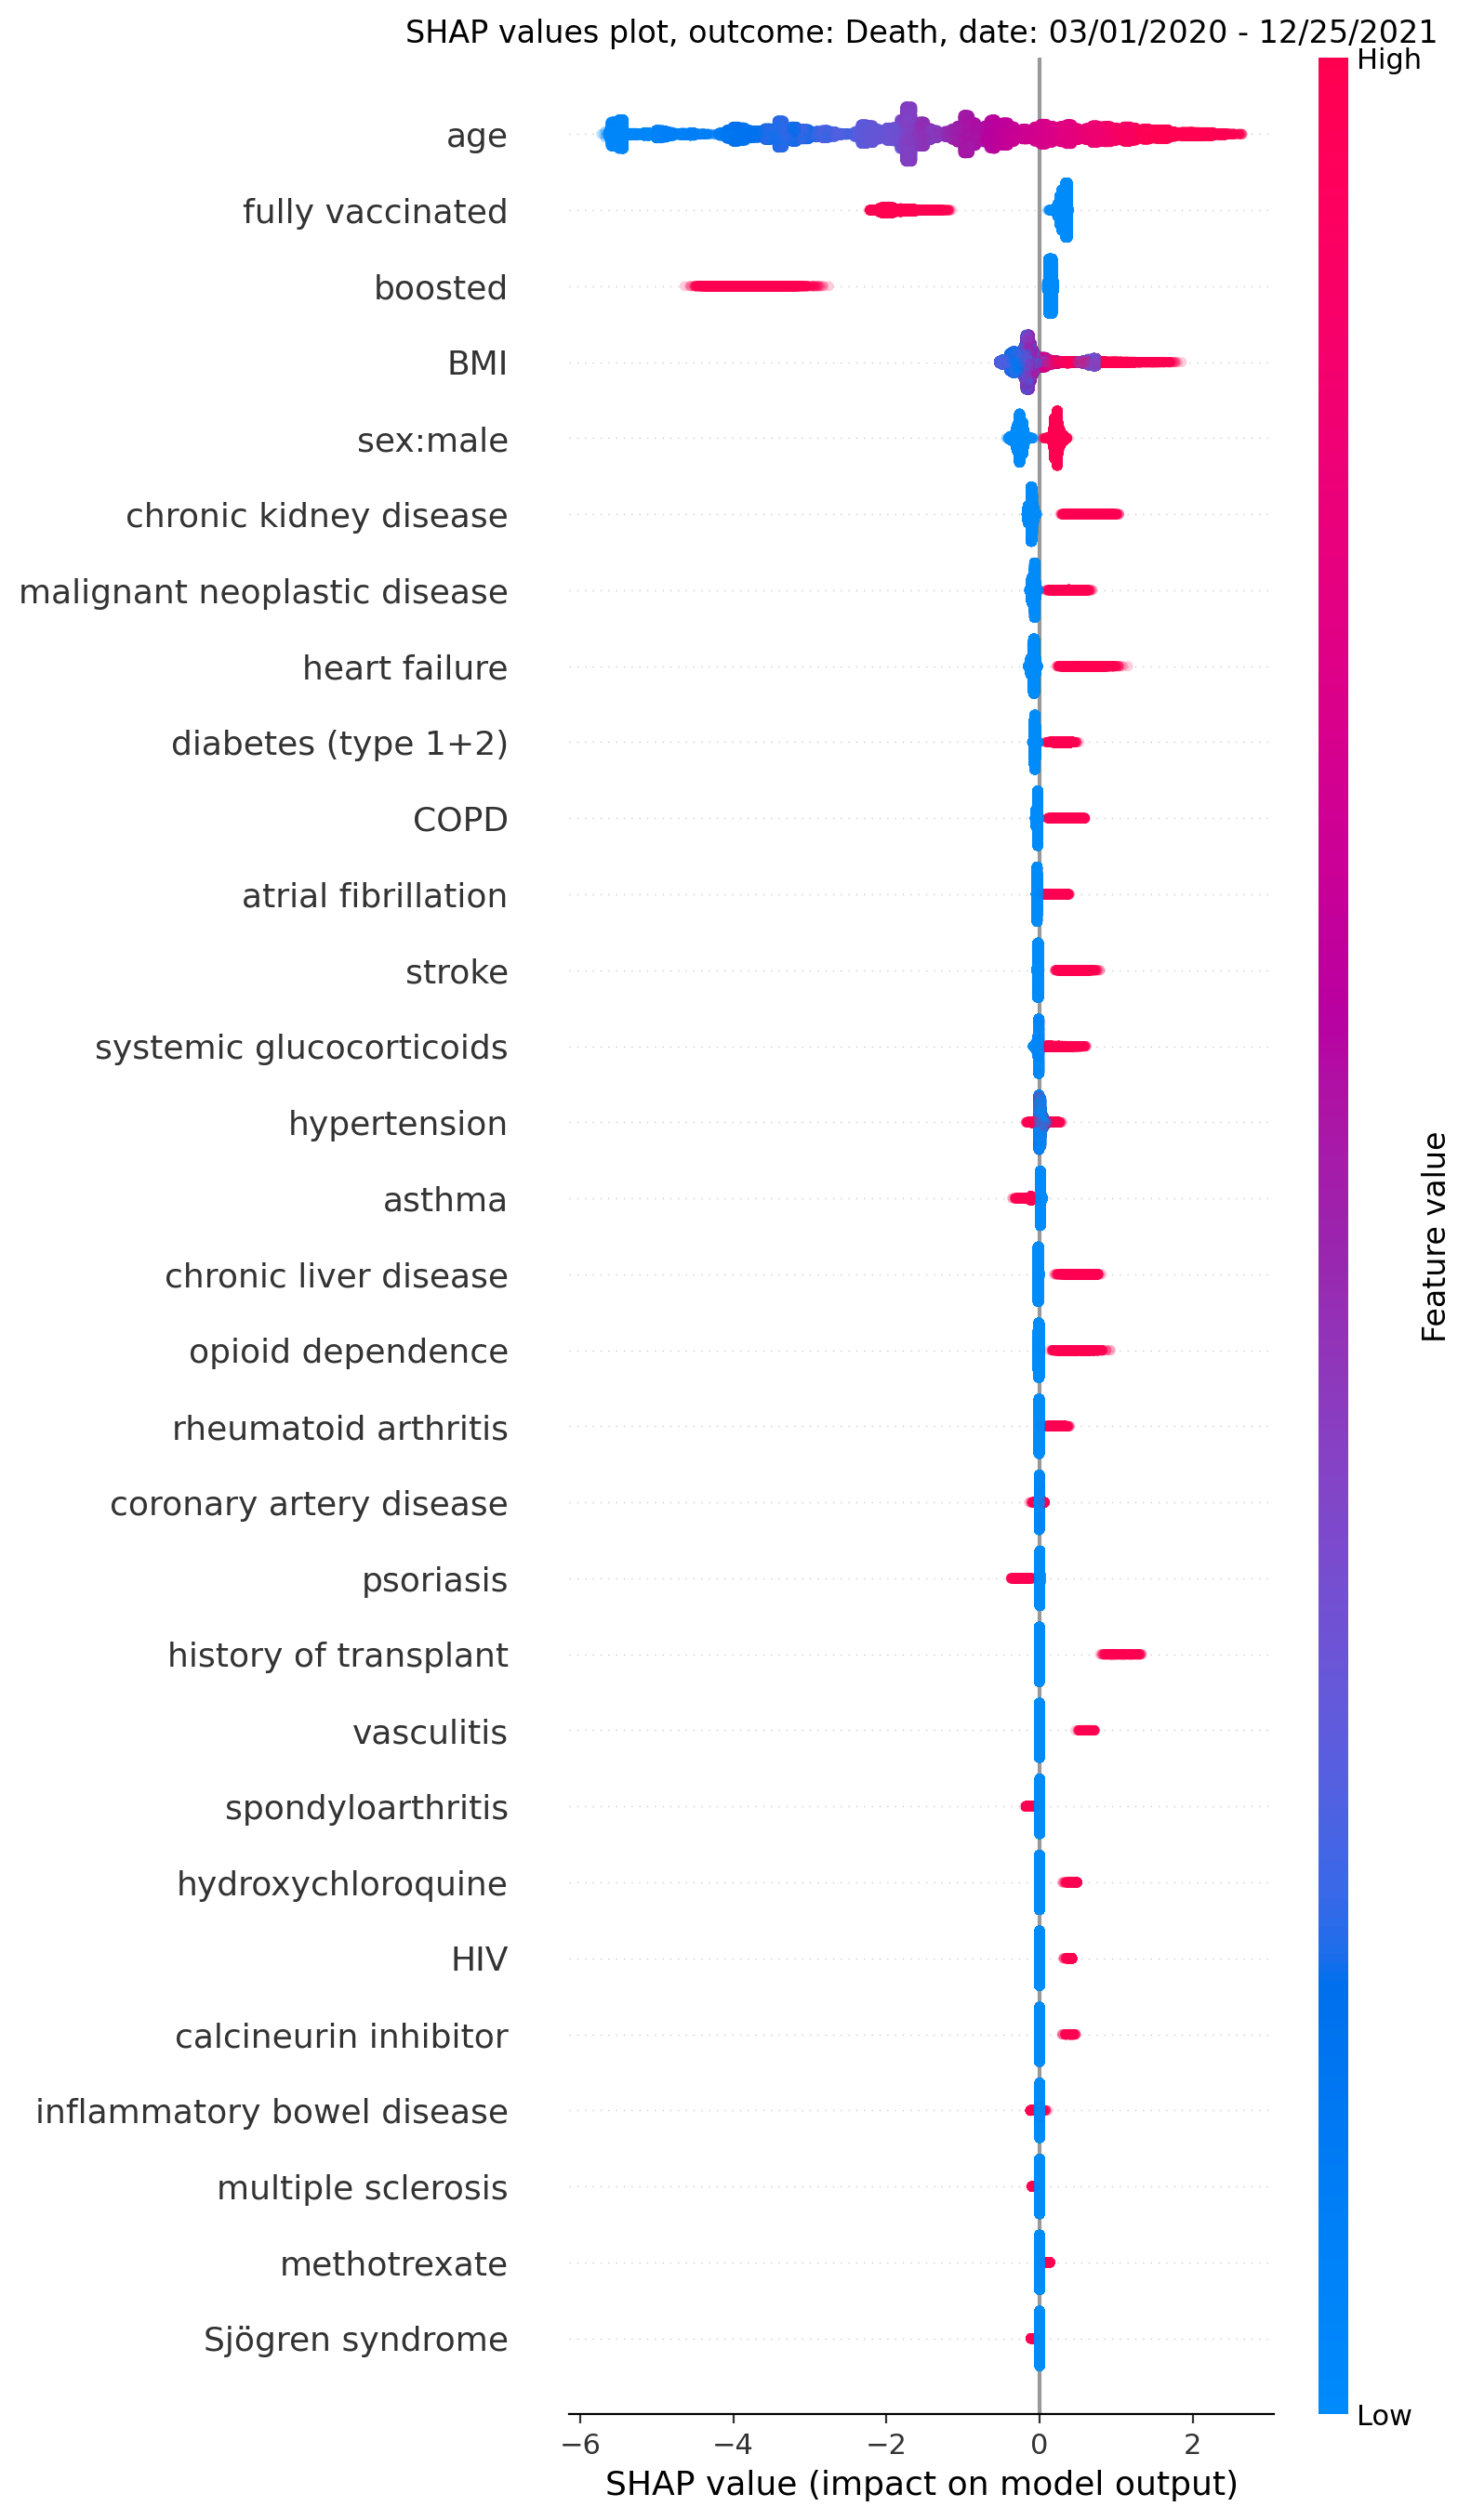

In [0]:
# shap.plots.waterfall(shap_values_arrary[0])

import matplotlib.pyplot as plt

## create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values_arrary[:,"age"], alpha=0.1)

## changing the rc parameters and plotting a line plot, the dpi function works!
plt.rcParams['figure.dpi'] = 200

# summarize the effects of all the features
# shap.plots.beeswarm(shap_values_arrary, max_display=20, plot_size = (15, 7))
shap.summary_plot(shap_values_arrary, max_display=30, alpha=0.2, show=False)

plt.title("SHAP values plot, outcome: Death, date: 03/01/2020 - 12/25/2021")
# plt.ylabel("SHAP value for the 'Age' feature")
# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want

plt.show()

## Following codes used to investigate interesting single features

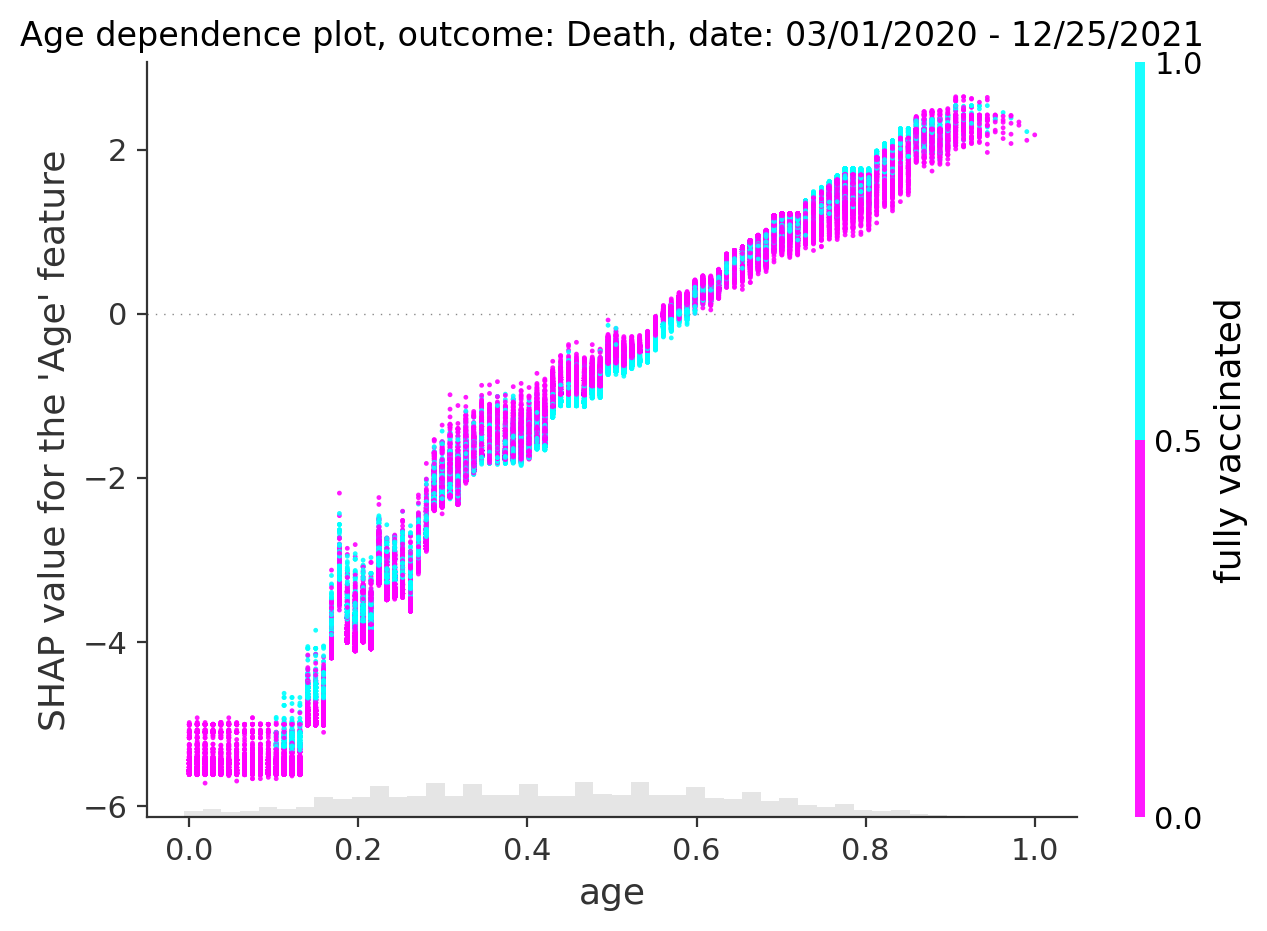

In [0]:
# by passing show=False you can prevent shap.dependence_plot from calling
# the matplotlib show() function, and so you can keep customizing the plot
# before eventually calling show yourself

## To explicitly control which feature is used for coloring you can pass a specific feature column to the color parameter.

## alpha: transparency can help reveal dense vs. sparse areas of the scatter plot
# for categorical (or binned) data adding a small amount of x-jitter makes
# thin columns of dots more readable

import matplotlib.pyplot as plt

## create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values_arrary[:,"age"], alpha=0.1)

## changing the rc parameters and plotting a line plot, the dpi function works!
plt.rcParams['figure.dpi'] = 200

## Dependant features: Vaccination_status_Fully, Vaccination_status_Booster, threeMo_prior_β_tubulin_polymerization_inhibitor_yes
shap.plots.scatter(shap_values_arrary[:,"age"], color=shap_values_arrary[:,"fully vaccinated"], alpha=0.9, dot_size=3, cmap=plt.get_cmap("cool_r"), show=False)
plt.title("Age dependence plot, outcome: Death, date: 03/01/2020 - 12/25/2021")
plt.ylabel("SHAP value for the 'Age' feature")
# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want

plt.show()

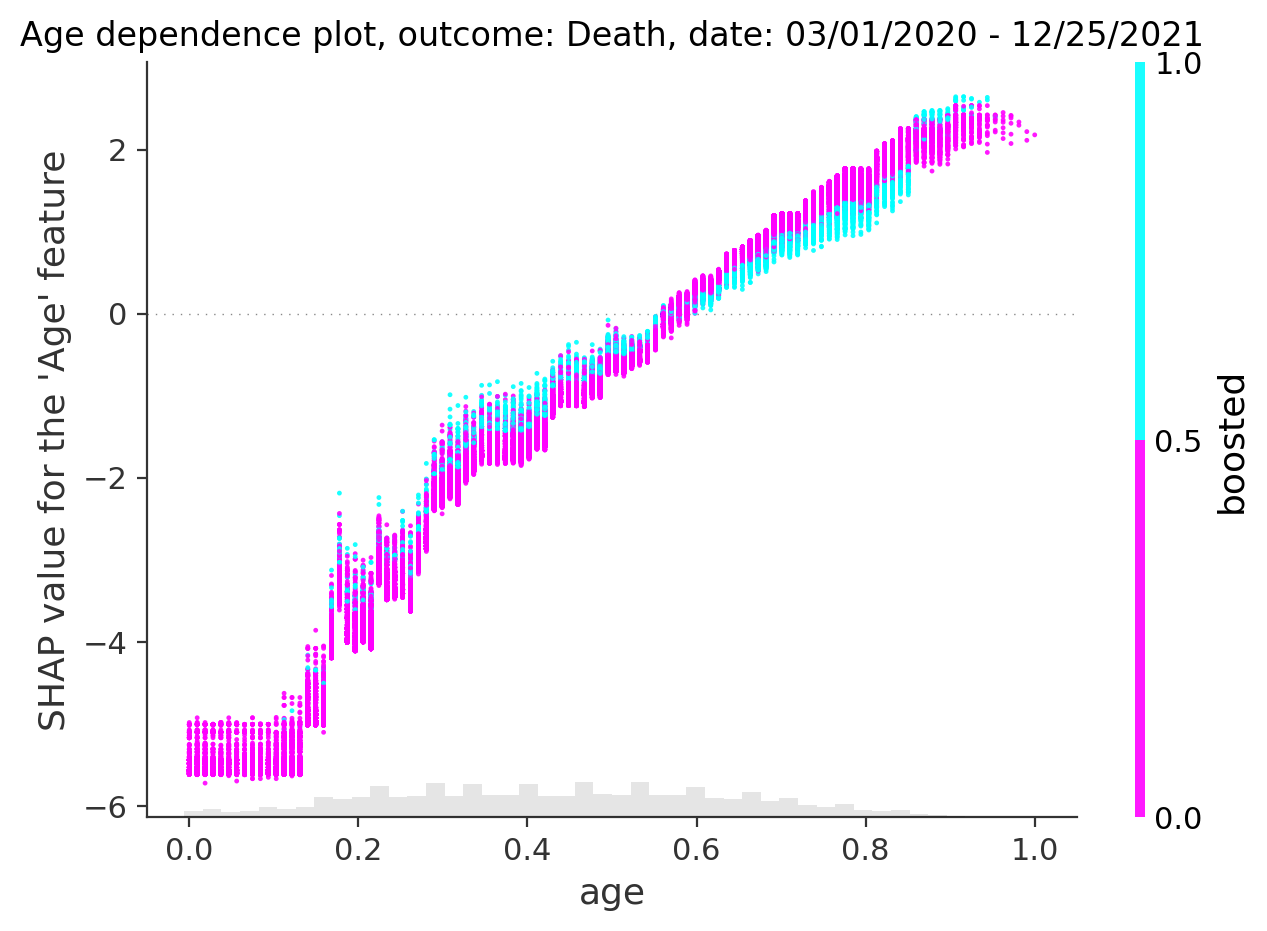

In [0]:
# by passing show=False you can prevent shap.dependence_plot from calling
# the matplotlib show() function, and so you can keep customizing the plot
# before eventually calling show yourself

## To explicitly control which feature is used for coloring you can pass a specific feature column to the color parameter.

## alpha: transparency can help reveal dense vs. sparse areas of the scatter plot
# for categorical (or binned) data adding a small amount of x-jitter makes
# thin columns of dots more readable

import matplotlib.pyplot as plt

## create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values_arrary[:,"age"], alpha=0.1)

## changing the rc parameters and plotting a line plot, the dpi function works!
plt.rcParams['figure.dpi'] = 200

## Dependant features: Vaccination_status_Fully, Vaccination_status_Booster, threeMo_prior_β_tubulin_polymerization_inhibitor_yes
shap.plots.scatter(shap_values_arrary[:,"age"], color=shap_values_arrary[:,"boosted"], alpha=0.9, dot_size=3, cmap=plt.get_cmap("cool_r"), show=False)
plt.title("Age dependence plot, outcome: Death, date: 03/01/2020 - 12/25/2021")
plt.ylabel("SHAP value for the 'Age' feature")
# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want

plt.show()

In [0]:
# # by passing show=False you can prevent shap.dependence_plot from calling
# # the matplotlib show() function, and so you can keep customizing the plot
# # before eventually calling show yourself

# ## To explicitly control which feature is used for coloring you can pass a specific feature column to the color parameter.

# ## alpha: transparency can help reveal dense vs. sparse areas of the scatter plot
# # for categorical (or binned) data adding a small amount of x-jitter makes
# # thin columns of dots more readable

# import matplotlib.pyplot as plt

# ## create a dependence scatter plot to show the effect of a single feature across the whole dataset
# # shap.plots.scatter(shap_values_arrary[:,"age"], alpha=0.1)

# ## changing the rc parameters and plotting a line plot, the dpi function works!
# plt.rcParams['figure.dpi'] = 200

# ## Dependant features: Vaccination_status_Fully, Vaccination_status_Booster, threeMo_prior_β_tubulin_polymerization_inhibitor_yes
# shap.plots.scatter(shap_values_arrary[:,"age_normalized"], color=shap_values_arrary[:,"JAK inhibitor"], alpha=0.7, dot_size=3, cmap=plt.get_cmap("cool"), show=False)
# plt.title("Age dependence plot, outcome: Death, date: 12/26/2021 - 07/25/2022")
# plt.ylabel("SHAP value for the 'Age' feature")
# # plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want

# plt.show()

In [0]:
# # by passing show=False you can prevent shap.dependence_plot from calling
# # the matplotlib show() function, and so you can keep customizing the plot
# # before eventually calling show yourself

# ## To explicitly control which feature is used for coloring you can pass a specific feature column to the color parameter.

# ## alpha: transparency can help reveal dense vs. sparse areas of the scatter plot
# # for categorical (or binned) data adding a small amount of x-jitter makes
# # thin columns of dots more readable

# import matplotlib.pyplot as plt

# ## create a dependence scatter plot to show the effect of a single feature across the whole dataset
# # shap.plots.scatter(shap_values_arrary[:,"age"], alpha=0.1)

# ## changing the rc parameters and plotting a line plot, the dpi function works!
# plt.rcParams['figure.dpi'] = 200

# ## Dependant features: Vaccination_status_Fully, Vaccination_status_Booster, threeMo_prior_β_tubulin_polymerization_inhibitor_yes
# shap.plots.scatter(shap_values_arrary[:,"age_normalized"], color=shap_values_arrary[:,"rituximab"], alpha=0.7, dot_size=3, cmap=plt.get_cmap("cool"), show=False)
# plt.title("Age dependence plot, outcome: Death, date: 12/26/2021 - 07/25/2022")
# plt.ylabel("SHAP value for the 'Age' feature")
# # plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want

# plt.show()

In [0]:
# temp = X[["age_normalized", "JAK inhibitor", "rituximab"]].copy()
# temp["row_num"] = temp.reset_index().index

# Pts_with_Jaki = temp[temp["JAK inhibitor"] == 1]

# JAKi_row_numbers = Pts_with_Jaki["row_num"]
# print(JAKi_row_numbers.values.tolist())

In [0]:
# ## Patients used as focus
# ## List with JAKi: 161955
# force_plot = shap.force_plot(explainer.expected_value, shap_values[143418,:], X.iloc[143418,:], matplotlib=False)
# shap_html = f"{shap.getjs()}{force_plot.html()}"
# displayHTML(shap_html)